# Spinodal Decomposition (Part II)


## Introduction

In this notebook, we continue our analysis of the spinodal decomposition model.


### Scope of the work

 1. We load the data (see the detail description of the datasets in the Part I).
 2. We find the most optimal number of clusters.
 3. We test baseline methods of finding the spaning-clusters (SC).
 4. We propagate labels from the cluster centroids to build a clean and balanced training dataset.
 5. We demonstrate how to train classifiers that are capable of detecting the SC without explicit access to the true labels.
 6. We test the performance of different models and we demonstrate improvement over the baseline.


### Part I: A Short Overview

In the 1st notebook we focused on data exploration and clustering methods. We compared various feature vector representation and we determined the optimal number of clusters. We identified a morphology class for which the microstructures merge into characteristic, macroscopic, spanning clusters (SC). Finally, using the learning-by-confusion schema, we determined the threshold value for the transition between two main morphology classes.

### Part III: A Short Overview

In the 3rd notebook we focus on training a predicting models.
 - We train a classifier, to predict the resulting morphology from the initial few frames of the simulation.
 - We train a regression model, to predict the initial parameters from the final simulation output.


### The Background

 - We have training and test data generated with a help of a classical, resource-intensive simulation.
 - Each simulation describes evolution of two phases.
 - We are interested in learning the final morphology.
 - We have three different (initial) parameters that we can control: mobility of phase A, `mobA`, mobility of phase B, `mobB`, and phase fraction, `frac`.
 
 
### Motivation

 - **Goal 1:** We would like to learn if the morphologies can be logically grouped into a number of distinctive classes. If yes, we would like to create a morphology map.
 - **Goal 2:** We would like to train a model to predict the expected morphology type from the initial (few) frames of the classical simulation.

In this notebook, we focus on the first goal.

### Library Imports

We will pre-load all libraries that we will use in that notebook.

The notebook was tested with python 3.8, CUDA 10.1 and with the following package versions:

    Package                           Version
    --------------------------------- ----------
    numpy                             1.18.5
    pandas                            1.1.5
    scikit-image                      0.18.0
    scikit-learn                      0.23.2
    scipy                             1.4.1
    tensorflow-gpu                    2.3.0
    tensorflow-hub                    0.10.0

In [1]:
# Standard libraries
import collections
import os
import json
import random
import sys
import time

# Libraries you must install (e.g. using pip install name_of_the_library)
import numpy
import pandas
import scipy
import skimage.measure
import sklearn.cluster
import sklearn.decomposition
import sklearn.manifold
import sklearn.metrics
import tensorflow
import tensorflow_hub

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Input Data

To see the detail analysis of the input data, see the first notebook, "Spinodal Decomposition (Part I)".

The original simulations were saved as 101x512x512 dimensional numpy arrays, with `float64` numbers that range from around -1.05 to +1.05. Here, in order to save the space, we encoded the numbers as `float16`. Additionally, to make the input more similar to the input of some popular CNN architectures, we changed the dimensions of each frame from 512x512 to 256x256 (replacing every block of 2x2 pixels by the mean value).

The compression was performed by the following code,

```python
    assert original_data.dtype == 'float64' 
    assert original_data.shape == (4998, 101, 512, 512, 1)
    
    last_frame = original_data[:,-1]
    resized_data = skimage.measure.block_reduce(last_frame, (1, 2, 2, 1), numpy.mean)
    resized_data = resized_data.astype('float16')
    
    assert resized_data.dtype == 'float16' 
    assert resized_data.shape == (4998, 256, 256, 1)
```

There was originally 5000 training and 500 test simulations (generated for different initial parameters; the initial values of the parameters were selected randomly from uniform distributions). However, 2 training simulations were corrupted. Additionally, we selected 1000 training simulations (20%) to create a validation set. Therefore, the number of simulations used to construct the training set was 3998.

The input data have discrete translational symmetry (the input data is represented on a torus; we have periodic-boundary conditions both up-down and left-right). We leveraged it to to augment the training instances (see the Data Augmentation in Section 4 below).

### Data Location

All the input data can be found at the ISI server `effectbig03` in the `/data/mjabram/share/spinodal_decomposition` folder.

In [2]:
# If you run this notebook localy, change the path so it match the location of your main data folder
DATA_PATH = '/raw/cah/shared/'

### The Simulation Data

We load the simulation data. We use a dataset, that contains only the last frame of the simulation.
For our convenience (e.g., to make it compatible with the `plotlib`), we cast the data back from `float16` to `float32`. Note, this doesn't mean, that our accuracy of the input data increased to `float32`. We still have only about 4 significant digits per number. However, this should not be a problem, since the majority of pixel values are either close to +1 or to -1 (there is very little pixels with values close to zero; thus, even with a lower numerical precision, we can correctly identify the positive and negative regions). 

In [3]:
# Load the training data
data = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000x_256f16.npy')).astype('float32')
data.shape, data.dtype

((4998, 256, 256, 1), dtype('float32'))

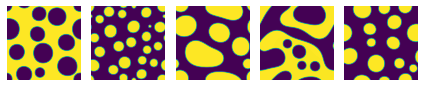

In [4]:
def plot_frames(data, *arr, cmap='viridis', title=None, axis=None):
    """Plot selected frames."""
    if title:
        print(title)
    fig, axes = plt.subplots(1, len(arr))
    for i, k in enumerate(arr):
        a = axes if len(arr) == 1 else axes[i]
        if not axis:
            a.axis('off');
        fig.tight_layout() 
        a.imshow(data[k], cmap=cmap)
    plt.show()

# Plot last frames from a few simulations
plot_frames(data, 0, 1, 2, 14, -1)  # note, we count the simulations from 0 not from 1

The original input ranges from around -1.04 to 1.04. However, most image recognition models expect the input to be in the `[0, 1]` range. Therefore, we clip the values that are below -1 or above 1, and then we rescale the input to be in the `[0, 1]` range.

(0.0, 1.0, 0.49998206)

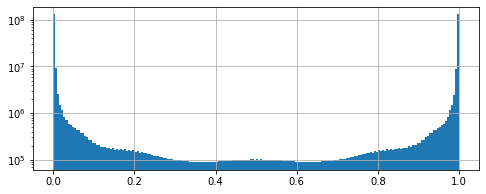

In [5]:
# Standarize the input data
data = numpy.where(data > 1, 1, data)
data = numpy.where(data < -1, -1, data)
data += 1
data /= 2

# Plot the distribution again (note, now the distribution is from 0 to 1)
fig, ax = plt.subplots()
pandas.Series(data.flatten()).hist(bins=200, figsize=(8, 3))
ax.set_yscale('log')
data.min(), data.max(), data.mean()

### Parameters

We load the initial parameters. There are three values for each simulation: the mobility of the phase A, `mobA`, the mobility of the phase B, `mobB`, and the phase fraction, `frac`.

The initial parameters were selected from uniform distributions. Mobility of the A and B phase were selected from `U(0, 100)`, while the phase fraction was selected from `U(-0.4, 0.4)`.

The phase fraction is (most likely; a confirmation is needed!) defined as `frac = phase A concentration - phase B concentration` with the constraint `phase A concentration + phase B concentration = 1`.

Again, for detail analysis, see the first notebook. We described there, e.g., a small discrepancy between the declared phase concentration and the measured one. However, we believe that this should not effect the results of this analysis.

In [6]:
# Load the parameters
parameters = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000p_256f16.npy'))
parameters = pandas.DataFrame(data=parameters, columns=['mobA', 'mobB', 'frac'])
parameters.tail()

,mobA,mobB,frac
4993,67.035086,46.664670,-0.158747
4994,94.223735,98.272281,0.148099
4995,2.031358,43.635881,0.238011
4996,14.542157,0.946535,0.029123
4997,18.476629,84.828663,-0.374032


### Connectivity Data

Looking at the simulations, we can notice that there are two obvious classes: one where the positive phase is dominant (yellow background, purple "bubbles") and another where the negative phase is dominant (purple background, yellow "bubbles"). However, as we will see in moment, we have also cases, that can not be easily accounted to one of those two classes.

We generated labels, checking if there is a path connecting pixels of one color from one edge to another edge. Specifically, we check if there is:
 - a vertical connection `v`. We say that there is such a connection, if there exists `k` for which there is a connected path of one color from `(0, k)` to `(n-1, k)`.
 - a horizontal connection `h`. We say that there is such a connection, if there exists `k` for which there is a connected path of one color from `(k, 0)` to `(k, n-1)`.
 
We assumed, that the connected path can be traveled only in vertical or horizontal directions. Meaning, that two pixels of one color that share one common corner are not connected.
 
We checked those connections with respect to:
 - both, negative phase (denoted as `neg` or `B`, and usually depicted by a purple color) and positive phase (denoted as `pos` or `A`, and usually depicted by a yellow color).
 - both, using and not-using the fact, that we have periodic boundary conditions (denoted below as `pbc`).

In [7]:
# Load and show the labels
connectivity = pandas.read_csv(os.path.join(DATA_PATH, 'cah_lastframe_train5000c_256f16.csv'))
connectivity.tail()

,pos,neg,pos_pbc,neg_pbc
4993,0,hv,0,hv
4994,hv,0,hv,0
4995,hv,0,hv,0
4996,0,0,hv,hv
4997,0,hv,0,hv


Note, that if both `pos=hv` and `neg=0`, it indicates that the positive phase is dominant (yellow background, purple "bubbles"). The opposite situation is when `pos=0` and `neg=hv`, then the negative phase is dominant (purple background, yellow bubbles).

However, there are a couple of examples that can not be easily classified as horizontal (h) or vertical (v). One of them are the simulations no. 4996 (see below). We will call those examples as _spanning clusters_ (SC). The name was chosen because if you account for the periodic boundary conditions, both negative and positive phase will have macroscopic (infinite) size.

The fact, that some cases were annotated as 0 in `pos` and `neg` but got non-zero value for `pos_pbc` and/or in `neg_pbc` usually means, that the spanning clusters are extended in the diagonal direction (see for example the simulation no. 2771).

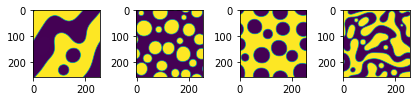

In [8]:
plot_frames(data, 2771, 4993, 4994, 4996, axis=True)

In [9]:
# Mark "spaning clusters" (sc), dominant positive (+), and dominant negative (-) cases
connectivity['sc'] = [int(row.pos != 'hv' and row.neg != 'hv') for _, row in connectivity.iterrows()]
connectivity['+'] = [int(row.pos == 'hv' and row.neg != 'hv') for _, row in connectivity.iterrows()]
connectivity['-'] = [int(row.pos != 'hv' and row.neg == 'hv') for _, row in connectivity.iterrows()]
connectivity.tail()

,pos,neg,pos_pbc,neg_pbc,sc,+,-
4993,0,hv,0,hv,0,0,1
4994,hv,0,hv,0,0,1,0
4995,hv,0,hv,0,0,1,0
4996,0,0,hv,hv,1,0,0
4997,0,hv,0,hv,0,0,1


**Summary:** The spanning clusters will become our central focus through this notebook. There are interesting, because they indicate a moment when the system switch from one main class of outcomes (phase A being connected and phase B being disconnected) to the second main class of outcomes (phase B being connected and phase A being disconnected).

We can also study this transition by analyzing the "natural scale" of the system. Approaching the transition, the size of the microscopic structures increases to reach macroscopic level. What is also characteristic, the final outcome become independent of the dynamical details of the system (namely, the mobility `mobA` and `mobB`). Those properties are part of the the universal scaling phenomena known from the statistical physics. 

### Feature Vectors (The Latent Space)

To create feature vector from an image we can use one of the pre-trained models available in TensorFlow Hub. Here, we decided to use the **ResNet V2** model. The key difference with the V1 is the use of batch normalization. ResNet 50 has 50 layers and was trained on standard ImageNet-1k detaset (ILSVRC-2012-CLS). The feature vector has size `2048`. The input images are expected to have color values in the range `[0,1]` and the expected size of the input images is `224x224` pixels by default, but other input sizes are possible (within limits). See more at https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4.

Note, that this model require 3-channel input. Therefore, we will just triple our output (each channel will have the same pictures). The entire procedure was done using the following code,

```python
data3 = numpy.repeat(data, 3, axis=-1)

m = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4", trainable=False),
])
m.build([None, 256, 256, 3])

feature_vector = m.predict(data3)
```

Here, to safe time, we will load the pre-computed feature vector from a file.

In [10]:
# To save time, we will just load the feature vector that we already pre-computed.
feature_vector = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_ResNetV2.npy'))
feature_vector.shape

(4998, 2048)

### Training and Validation Dataset

We take random 80% of dataset for training and we leave rest for validation.

In [11]:
# Create training and validation set index
indexes = list(range(len(data)))

random.seed(123)  # just for the reproducibity, we set here a random number generator seed
random.shuffle(indexes)

train_n = int(len(data)*0.8)
train_idx = numpy.array(indexes[:train_n])
val_idx = numpy.array(indexes[train_n:])

train_idx[:5], train_idx.shape, val_idx[:5], val_idx.shape

(array([1823, 3764, 2702,  464,  994]),
 (3998,),
 array([1095, 1042, 2876, 3791, 3932]),
 (1000,))

In [12]:
# Create training and validation dataset
train_x = feature_vector[train_idx]
train_p = parameters.iloc[train_idx]
train_c = connectivity.iloc[train_idx]
train_data = data[train_idx]

val_x = feature_vector[val_idx]
val_p = parameters.iloc[val_idx]
val_c = connectivity.iloc[val_idx]
val_data = data[val_idx]

train_x.shape, train_p.shape, val_x.shape, val_p.shape, train_data.shape

((3998, 2048), (3998, 3), (1000, 2048), (1000, 3), (3998, 256, 256, 1))

## Section 2: Clustering

For the clustering method, we choose K-Means algorithm. We use `k-means++` algorithm to chose the initial positions of the centroids, cf. David Arthur and Sergei Vassilvitskii, "k-Means++: The Advantages of Careful Seeding" (2007). Each time we run the algorithm several time and we chose the results that correspond to the lowest inertia.

```python
kmeans = sklearn.cluster.KMeans(n_clusters=i, n_init=5, init='k-means++').fit(features)
```

To chose the right number of clusters, we look booth at the inertia plot and at the silhouette score. The optimal number of clusters should correspond to an elbow of the inertia plot and to the maximum of the silhouette score. Finally, we look also at the silhouette diagrams, that show both the number of instances each cluster contains and the sorted silhouette coefficients of the instances in each cluster. From those diagrams we can examine how robust are the assignments to different classes.

Note, that we use only the training data to train the k-Means algorithm (we do not use here the validation dataset; the validation set will be used later to tune the hyperparameters of our models).

 2: inertia = 1117311, silhouette=0.304
 3: inertia = 781585, silhouette=0.366
 4: inertia = 626526, silhouette=0.398
 5: inertia = 488184, silhouette=0.428
 6: inertia = 444362, silhouette=0.367
 7: inertia = 403214, silhouette=0.308


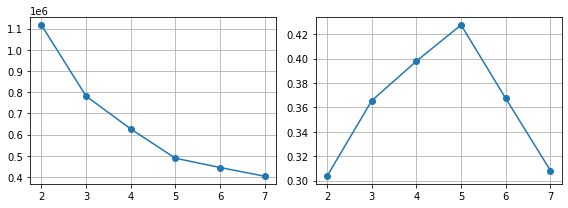

In [13]:
def find_optimal_number_of_clusters(features):
    """Plot the inertia and the silhouette score."""
    x = list(range(2, 8))
    inertia, silhouette = [], []
    for i in x:
        kmeans = sklearn.cluster.KMeans(n_clusters=i, n_init=5, init='k-means++').fit(features)
        score = sklearn.metrics.silhouette_score(features, kmeans.labels_)
        inertia.append(kmeans.inertia_)
        silhouette.append(score)
        print('{:2d}: inertia = {:.0f}, silhouette={:.3f}'.format(i, kmeans.inertia_, score))
        
    # Plot the inertia and the silhouette score
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    axes[0].plot(x, inertia, 'o-'); axes[0].grid()
    axes[1].plot(x, silhouette, 'o-'); axes[1].grid()
    fig.tight_layout()
    plt.show()
    
    
# example
find_optimal_number_of_clusters(features=train_x)

**Interpretation:** As we see, the optimal number of clusters seems to be 5.

To examine how robust are the assignments to different classes, below we plot the clusters using the first two principal components, and we plot the Silhouette diagrams.

k = 2 Counter({0: 2251, 1: 1747})


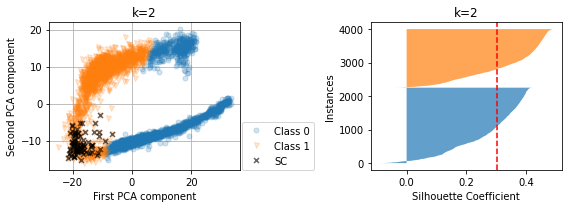

k = 3 Counter({0: 1612, 1: 1541, 2: 845})


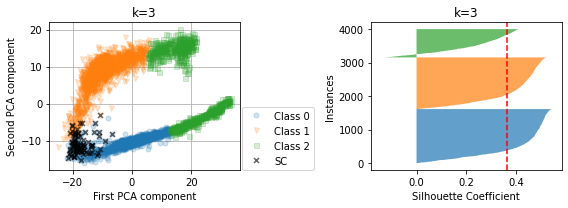

k = 4 Counter({0: 1437, 1: 1403, 2: 786, 3: 372})


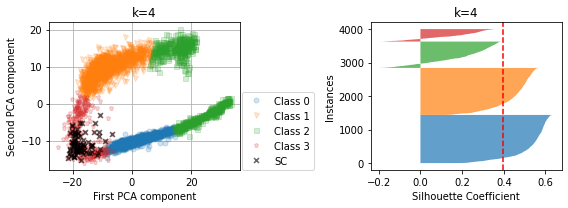

k = 5 Counter({0: 1392, 1: 1295, 4: 491, 2: 455, 3: 365})


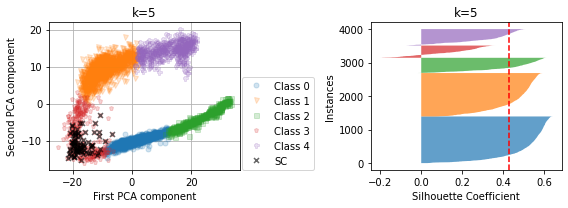

k = 6 Counter({0: 1392, 1: 964, 4: 495, 5: 455, 3: 360, 2: 332})


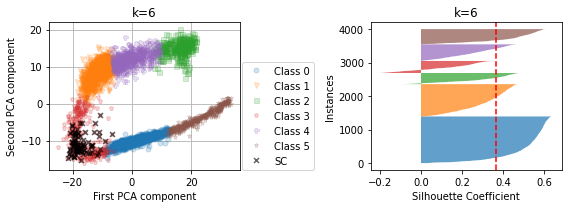

In [14]:
def plot_clusters(fig, ax, k, instances, labels, legend=True, sc=train_c.sc):
    """Plot Clusters."""
    global train_p
    #assert k == len(set(labels))
    
    markers = ['o', 'v', 's', 'p', 'P', '*', 'd']
    
    for i in range(k):
        x = instances[labels == i, 0]
        y = instances[labels == i, 1]
        ax.plot(
            x, y, marker=markers[i], linestyle="", label=f'Class {i}',
            markersize=5, alpha=0.2)
    
    # Mark the SC instances
    if sc is not None:
        x = instances[sc == 1, 0]
        y = instances[sc == 1, 1]
        ax.plot(
            x, y, marker='x', linestyle="", label='SC', alpha=0.6,
            color='black', markeredgewidth=1.5, markersize=5)
    
    ax.title.set_text("k={}".format(k))
    ax.set_xlabel('First PCA component')
    ax.set_ylabel('Second PCA component')
    if legend:
        ax.legend(loc=(1.01, 0));
    ax.grid(); fig.tight_layout()
    
    
def print_silhouette_diagram(fig, ax, k, x, labels):
    """Print the Silhouette Diagram"""
    assert k == len(set(labels))

    silhouette_coefficients = sklearn.metrics.silhouette_samples(x, labels)
    score = sklearn.metrics.silhouette_score(x, labels)

    pos = 0
    for i in range(k):
        coeffs = silhouette_coefficients[labels == i]
        coeffs.sort()
        ax.fill_betweenx(numpy.arange(pos, pos + len(coeffs)), 0, coeffs, alpha=0.7)
        pos += len(coeffs)
        
    ax.axvline(x=score, color="red", linestyle="--")
    ax.title.set_text("k={}".format(k))
    ax.set_ylabel("Instances")
    ax.set_xlabel("Silhouette Coefficient")
    fig.tight_layout() 
    

# test different number of clusters
x = train_x

for k in (2, 3, 4, 5, 6):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init='k-means++', random_state=123).fit(x)
    instances = sklearn.decomposition.PCA(n_components=k).fit_transform(x)
    print('k = {}'.format(k), collections.Counter(kmeans.labels_))
    
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    plot_clusters(fig, axes[0], k=k, instances=instances, labels=kmeans.labels_, legend=True)
    print_silhouette_diagram(fig, axes[1], k=k, x=x, labels=kmeans.labels_)
    plt.show()

**Interpretation:** Looking at the "elbow" of the inertia or checking the Silhouette coefficient, the optimal number of clusters seems to be `k=5`. However, looking at the Silhouette diagrams, we see that different number of clusters could also be reasonable. When we increase the number of clusters, we tend to divide the "arms" into smaller regions (look at the left figures). This might imply that there is a hierarchy of clusters in the "arms". This can also indicate, that the character of our input changes in more-less continuous way.

Additionally, we see that the cluster in the "elbow" (the red cluster), has small number of relatively dis-similar objects. This might indicated, that the characteristics of objects change rapidly in that region (when going from one instance to another). Using dark crosses, we marked all SC instances. We see, that the SC instances are a subset of the red cluster.

### Class Examples

Let's chose the number of classess `k=5` (it was the number of clusters, for which the silhouette score was maximal). We will cluster again and we will plot examples of instances from each class. 

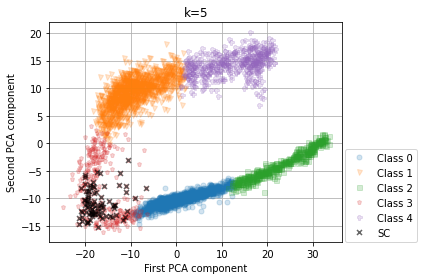

In [15]:
x = train_x
pca = sklearn.decomposition.PCA(n_components=5).fit(x)
instances = pca.transform(x)
kmeans = sklearn.cluster.KMeans(n_clusters=5, n_init=1, init='k-means++', random_state=123).fit(x)
train_y = kmeans.labels_

fig, axes = plt.subplots(1, 1)
plot_clusters(fig, axes, k=5, instances=instances, labels=train_y)

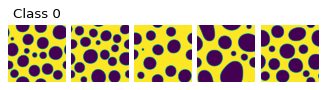

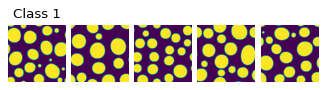

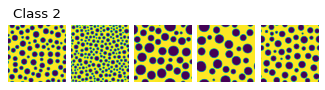

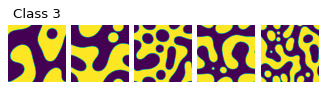

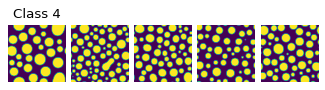

In [16]:
def plot_classes(img, labels, width=5, shuffle=False):
    """Plot figures."""
    classes = set(labels)
    
    for c in classes:
        selected = img[labels == c]
        
        if shuffle:
            numpy.random.shuffle(selected)
            
        selected = selected[:width]

        fig, axes = plt.subplots(1, width, dpi=80, figsize=(width, 1))
        for i, m in enumerate(selected):
            axes[i%width].imshow(m)
            axes[i%width].axis('off')
            if i == 0:
                axes[i%width].set_title(f'Class {c}')
            
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

# Plot a few random examples from each class
numpy.random.seed(123)
plot_classes(train_data, labels=train_y, width=5, shuffle=True)

**Interpretation:**
 - Class 0 contains examples, where positive phase is dominant (as we will see later, cases where `frac > 0`) and where mobility of the positive phase is large (`mobA >> 1`).
 - Class 1 contains examples, where negative phase is dominant (`frac < 0`) and where mobility of the negative phase is large (`mobB >> 1`).
 - Class 2 contains examples, where positive phase is dominant (`frac > 0`) and where mobility of the positive phase is small (`mobA << 100`).
 - Class 3 contains examples, where there is a balance between the positive and the negative phases (`frac` close to 0).
 - Class 4 contains examples, where negative phase is dominant (`frac < 0`) and where mobility of the negative phase is small (`mobB << 100`).

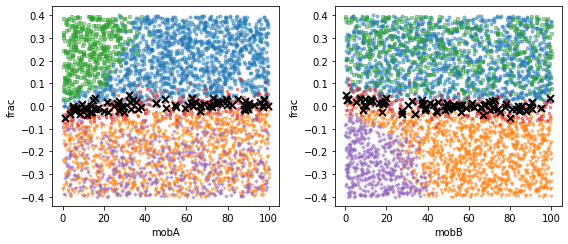

In [17]:
def plot_in_parameters_space(fig, ax, xname, yname, k, labels):
    """Plot in the parameters space."""
    global parameters, connectivity
    markers = ['o', 'v', 's', 'p', 'P', '*', 'd']
    
    for i in range(k):
        x = train_p[xname][labels == i]
        y = train_p[yname][labels == i]
        ax.plot(x, y, marker=markers[i], linestyle="", label=f'Class {i}', markersize=3, alpha=0.45)
    
    # Mark SC instances
    x = train_p[xname][train_c.sc == 1]
    y = train_p[yname][train_c.sc == 1]
    ax.plot(x, y, marker='x', linestyle="", label='SC', color='black', markeredgewidth=2, markersize=7)

    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    fig.tight_layout()
    

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8,3.5))
plot_in_parameters_space(fig, axes[0], 'mobA', 'frac', k=5, labels=train_y)
plot_in_parameters_space(fig, axes[1], 'mobB', 'frac', k=5, labels=train_y)

**Summary:**
 - Class 0 consists of examples were positive phase is dominant and mobility of the positive phase `mobA` is large.
 - Class 1 consists of examples were negative phase is dominant and mobility of the negative phase `mobB` is large.
 - Class 2 consists of examples were positive phase is dominant and mobility of the positive phase `mobA` is small.
 - Class 4 consists of examples were negative phase is dominant and mobility of the negative phase `mobB` is small.
 - Class 3 consists of examples were fraction of the positive and negative phase is equal. Those conditions correspond to situation when dis-connected regions of phase (either the positive or the negative one) merge into connected structures. This happen irrelevant of the value of the mobility `mobA` or `mobB` (the universality property of the system).

## Section 3: Baseline Models

In this toy-model, we were able to explicitly detect and label all SC instances. However, in more complex scenarios, we might not be so lucky. For example, in physical vapor deposition (PVD) simulations, we might be interested in learning how to obtain a particular microstructure topology. We might have just a few, manually labeled examples while the rest of our training data might be unlabeled.

Therefore, we ask here a question, if we can train a classified that can help us to detect the SC instances without explicitly using the SC labels.

### Baseline 1: Naive Approach

The first, the most naive approach would be to manually find a few SC instance. Next, we could measure distance of other instances from the known SC examples in the latent space. The hypothesis is, that instances close in the latent space are alike. Thus, all instances close to SC instances in the latent space could represent SC as well.

We will use L2 metric to measure distance in the latent space.

Later we will assume that we do not know which instance in the training set is SC. We will only assume, in order to tune the hyperparametes of the models, that we know the true labels of a (relatively small) validation set. Therefore, to make things comparable, in this baseline approach we will do the same. We will assume that we do not know the true labels for the training set; we will only use information which instance from the validation set is SC.

In [18]:
# Find how many SC examples we have in the validation set
collections.Counter(val_c.sc == 1)

Counter({False: 983, True: 17})

In [19]:
# Find index numbers of the SC instances
sc_idx = numpy.argwhere(val_c.sc.to_numpy() == 1).flatten()
sc_idx

array([ 76, 186, 364, 379, 453, 481, 516, 549, 615, 682, 714, 820, 825,
       851, 871, 938, 942])

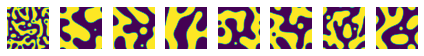

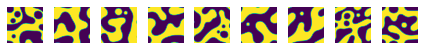

In [20]:
# Plot some the "known" SC instances from the validation set
plot_frames(val_data, *sc_idx[:8], axis=False)
plot_frames(val_data, *sc_idx[8:], axis=False)

In [21]:
# Calculate the center of the known SC instances in the latent space
sc_center = val_x[sc_idx].mean(axis=0)
sc_center.shape

(2048,)

In [22]:
# Calculate distance from the sc_center; Use L2 metric
val_distance = numpy.linalg.norm(val_x - sc_center, axis=1)
train_distance = numpy.linalg.norm(train_x - sc_center, axis=1)

train_distance.shape, val_distance.shape

((3998,), (1000,))

In [23]:
# Calculate AUC for the validation set
# Note, that this number might be too optimistic since we test with the same SC instances
# that were used to determine the sc_center
fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_c.sc, 1/val_distance, pos_label=1)
sklearn.metrics.auc(fpr, tpr)

0.981150140625935

In [24]:
# Calculate AUC for the training set
# In this case, this number is more realistic since we used instances that were not
# used to determine the sc_center
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_c.sc, 1/train_distance, pos_label=1)
sklearn.metrics.auc(fpr, tpr)

0.9598267513443803

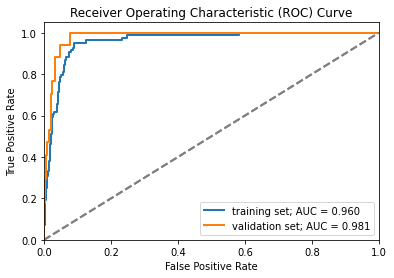

In [25]:
def plot_roc_curve(fig, ax, fp, tp, info, style='-'):
    """Plot the ROC curve."""
    auc = sklearn.metrics.auc(fp, tp)
    ax.plot(fp, tp, style, lw=2, label='{}; AUC = {:.3f}'.format(info, auc))
    ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")

# Plot the ROC curve
fig, axes = plt.subplots(1, 1)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_c.sc, 1/train_distance, pos_label=1)
plot_roc_curve(fig, axes, fpr, tpr, info='training set')
fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_c.sc, 1/val_distance, pos_label=1)
plot_roc_curve(fig, axes, fpr, tpr, info='validation set')

**Interpretation:** Note, that despite the name, to determine the average feature vector for SC instances, we used the instances from the validation set not from the training set (see the explanation above; we wanted just to keep the same number of known SC instances in each scenario). Thus, the AUC performance measured on the validation set is too optimistic, since the same instances were used to calculate `sc_center` and to measure the AUC score. Later (see the last section) we checked the performance on the test dataset, so everything was done correctly.

### Baseline 2: Finding SC by Solving an Auxiliary Task (a Teacher-Student Framework)

We can train a classifier to perform a more general task (e.g., we can take the labels generated by k-Means and then train another classifier - a form of a Teacher-Student Framework).

After the training is completed, we evaluate the classifier on the specific goal of finding the SC instances.

In [26]:
# Simple CNN model (based on AlexNet)
m0 = tensorflow.keras.models.Sequential()

m0.add(tensorflow.keras.layers.Conv2D(
    128, (11, 11), strides=4, padding="same", activation="relu", input_shape=(256, 256, 1)))
m0.add(tensorflow.keras.layers.BatchNormalization())
m0.add(tensorflow.keras.layers.MaxPooling2D((4, 4), strides=4))

m0.add(tensorflow.keras.layers.Conv2D(256, (5, 5), strides=1, padding="same", activation="relu"))
m0.add(tensorflow.keras.layers.BatchNormalization())
m0.add(tensorflow.keras.layers.MaxPooling2D((4, 4), strides=2))

m0.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m0.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m0.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m0.add(tensorflow.keras.layers.BatchNormalization())
m0.add(tensorflow.keras.layers.MaxPooling2D((2, 2)))

m0.add(tensorflow.keras.layers.Flatten())
m0.add(tensorflow.keras.layers.Dense(512, activation="relu"))
m0.add(tensorflow.keras.layers.Dropout(0.25))
m0.add(tensorflow.keras.layers.Dense(5, activation='sigmoid'))
m0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       15616     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         5

In [27]:
# Simple CNN model (based on AlexNet)
m0 = tensorflow.keras.models.Sequential()

m0.add(tensorflow.keras.layers.Conv2D(
    128, (11, 11), strides=4, padding="same", activation="relu", input_shape=(256, 256, 1)))
m0.add(tensorflow.keras.layers.BatchNormalization())
m0.add(tensorflow.keras.layers.MaxPooling2D((4, 4), strides=4))

m0.add(tensorflow.keras.layers.Conv2D(256, (5, 5), strides=1, padding="same", activation="relu"))
m0.add(tensorflow.keras.layers.BatchNormalization())
m0.add(tensorflow.keras.layers.MaxPooling2D((2, 2), strides=2))

m0.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m0.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m0.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m0.add(tensorflow.keras.layers.BatchNormalization())
m0.add(tensorflow.keras.layers.MaxPooling2D((2, 2), strides=2))

m0.add(tensorflow.keras.layers.Flatten())
m0.add(tensorflow.keras.layers.Dense(512, activation="relu"))
m0.add(tensorflow.keras.layers.Dropout(0.25))
m0.add(tensorflow.keras.layers.Dense(5, activation='softmax'))
m0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 128)       15616     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)        

In [28]:
# Compile
m0.compile(
    optimizer=tensorflow.keras.optimizers.Adam(5e-5),
    loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=tensorflow.keras.metrics.AUC(multi_label=True, name='auc')  # average with respect to classes
)

# Train
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='auc', patience=2, min_delta=0.001, mode='max'
)

m0_log =  m0.fit(
    train_data, tensorflow.one_hot(train_y, depth=5), epochs=30, verbose=1, callbacks=[callback]
)

Epoch 1/30
125/125 [==============================] - 2s 17ms/step - loss: 0.6287 - auc: 0.9360: 1s - los
Epoch 2/30
125/125 [==============================] - 2s 17ms/step - loss: 0.1867 - auc: 0.9927
Epoch 3/30
125/125 [==============================] - 2s 17ms/step - loss: 0.0963 - auc: 0.9978
Epoch 4/30
125/125 [==============================] - 2s 17ms/step - loss: 0.0632 - auc: 0.9993
Epoch 5/30
125/125 [==============================] - 2s 17ms/step - loss: 0.0539 - auc: 0.9990
Epoch 6/30
125/125 [==============================] - 2s 17ms/step - loss: 0.0354 - auc: 0.9998


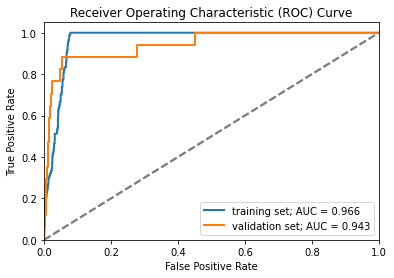

In [29]:
fig, axes = plt.subplots(1, 1)

pred = m0.predict(train_data)[:,3]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_c.sc, pred, pos_label=1)
plot_roc_curve(fig, axes, fpr, tpr, info='training set')

pred = m0.predict(val_data)[:,3]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_c.sc, pred, pos_label=1)
plot_roc_curve(fig, axes, fpr, tpr, info='validation set')

## Section 4: Label Propagation

We will select instances that are close to the centroids determined by the k-Means. We chose equal number of instances per class (for example 200 examples per class).

Instances that are far from the cluster centroids might be easily accounted to a wrong class. This can confuse our model and yield worse accuracy overall. In contrary, by training on instances that are "certain", we make sure that the model learn to detect the most characteristic features.

Finally, we leverage the fact, that SC instances are a subset of the cluster no. 3. We propagating labels from the SC instances to all (restricted) members of the cluster no. 3. Note, that doing this, we do not need true labels that specify which training instance is SC and which not - something what would be very labor intensive; we need only information that _some_ examples from the cluster no. 3 were _similar_ to the few SC instances that we identified.

### The Most Representative Instances

In [30]:
# Report clustr size
collections.Counter(kmeans.labels_)

Counter({1: 1295, 3: 365, 0: 1392, 4: 491, 2: 455})

In [31]:
# Calculate distance from each centroid
x = train_x
distance = kmeans.fit_transform(x)
distance[:3], distance.shape

(array([[21.641592, 14.55849 , 28.480679, 30.724394, 14.638975],
        [20.930096,  8.703479, 32.33739 , 25.782999, 20.675365],
        [22.837132,  5.33949 , 35.49066 , 26.229448, 25.079906]],
       dtype=float32),
 (3998, 5))

In [32]:
# Select the distance from the centroid of the assigned class
centroid_distance = distance[numpy.arange(len(x)), kmeans.labels_]
assert all(distance.min(axis=-1) == centroid_distance)

# Chose top N instances closest to the centroid
for i in range(kmeans.n_clusters):
    is_in_the_cluster = kmeans.labels_ == i
    cutoff_distance = sorted(centroid_distance[is_in_the_cluster])[199]
    above_cutoff = (centroid_distance > cutoff_distance)
    centroid_distance[is_in_the_cluster & above_cutoff] = -1
    
# Create a clean datasets
partially_propagated = (centroid_distance != -1)
train_clean_x = train_x[partially_propagated]
train_clean_y = kmeans.labels_[partially_propagated]
train_clean_c = train_c[partially_propagated]
train_clean_data = train_data[partially_propagated]

train_clean_x.shape, train_clean_y.shape, train_clean_c.shape, train_clean_data.shape

((1000, 2048), (1000,), (1000, 7), (1000, 256, 256, 1))

In [33]:
# Check that we have equal number of instances from each class
collections.Counter(train_clean_y)

Counter({1: 200, 4: 200, 0: 200, 3: 200, 2: 200})

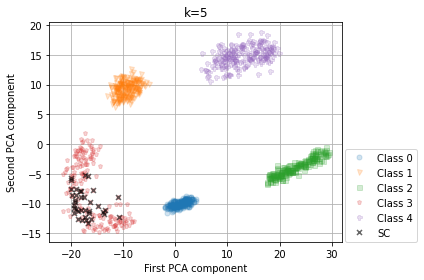

In [34]:
# Show the selected instances on a plot (using the first two PCA components)
fig, axes = plt.subplots(1, 1)
clean_instances = pca.transform(train_clean_x)

plot_clusters(fig, axes, k=5, instances=clean_instances, labels=train_clean_y, sc=train_clean_c.sc)

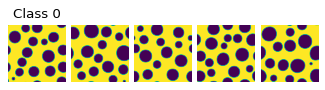

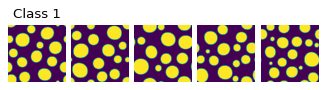

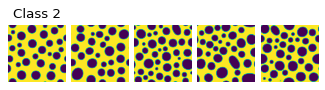

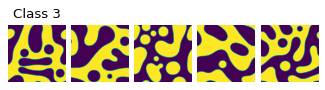

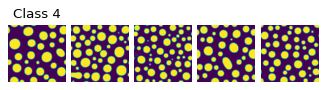

In [35]:
# show the instances from each "clean" cluster
plot_classes(train_clean_data, labels=train_clean_y, width=5)

**Summary:** Note, that examples from each class are now more homogenous then before. For example, the size of the "bubbles" are roughly constant in each class. This make the cut easier to interpret. For example, class 0 has examples where positive phase is dominant and value of the`mobA` parameter is large (that results in the positive class to quickly merge together). In contrast, class 2 contains examples where positive phase is also dominant, but the value of the `mobA` parameter is very low.

You can compare this with the previous case, where all instances were used. The cut's between different classes (e.g., class 0 and class 2) were not as obvious; there were many instances that were close to the class border in the latent space.

### Data Augmentation

I can augment the data, using the fact that we have periodic boundary conditions. I will randomly translate each instance by a vector.

Note, that the CNN networks are invariant to the position of various features. However, they do not encode explicitly the periodic boundary conditions. By performing that augmentation, we can implicitly teach that invariance.

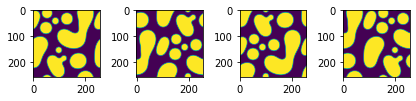

In [36]:
def roll(s, i, j):
    """Offset the input by i, j using periodic boundary conditions."""
    s = numpy.roll(s, i, axis=0)
    s = numpy.roll(s, j, axis=1)
    return s

# example
a = train_clean_data[13]
b = roll(a, 100, 100)
c = roll(a, 100, 0)
d = roll(a, 0, 100)
plot_frames([a, b, c, d], 0, 1, 2, 3, axis=True)

In [37]:
augmented_train_data = []
augmented_train_y = []
augmented_train_sc = []

for img, lab, sc in zip(train_clean_data, train_clean_y, train_clean_c.sc):
    for i, j in numpy.random.randint(256, size=(8, 2)):  # we create 8 examples from each frame
        augmented_train_data.append(roll(img, i=i, j=j))
        augmented_train_y.append(lab)
        augmented_train_sc.append(sc)

augmented_train_data = numpy.array(augmented_train_data)
augmented_train_y = numpy.array(augmented_train_y)
augmented_train_sc = numpy.array(augmented_train_sc)
augmented_train_data.shape, augmented_train_data.dtype, augmented_train_y.shape, augmented_train_y.dtype

((8000, 256, 256, 1), dtype('float32'), (8000,), dtype('int32'))

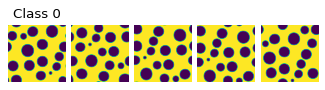

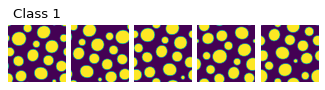

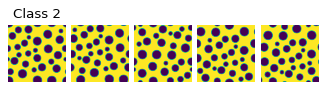

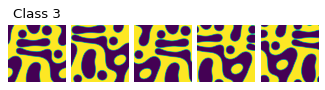

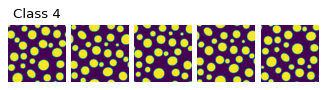

In [38]:
# show examples
plot_classes(augmented_train_data, labels=augmented_train_y, width=5)

## Section 5: Training

The entire idea is to train a classifier that can detect SC instances, without explicitly using the true labels. We will exploit a variant of a Student-Teacher framework, where our classifier is trained to solve an auxiliary task: to find a correct class with the labels supplied by the k-Means algorithm.

We assume, that we know only a handful of SC examples from the validation set. We will use the validation set to tune the hyperparameters of the network and to select the best performing model.

### Validation and Test Labels

There are 17 positive cases (SC instances) in the validation set (see below). We also identified, that without exception, the SC instances lie in the cluster no. 3 (see below as well). Therefore, we will use the label propagation technique, by identifying examples that lie close to the centroid of the cluster no. 3 as SC instances (just for the training purpose).

In [39]:
# Construct the validation labels
SC_CLASS_NUMBER = 3
val_y = numpy.array(val_c.sc == 1).astype('int8')*SC_CLASS_NUMBER
collections.Counter(val_y)

Counter({0: 983, 3: 17})

In [40]:
kmeans.predict(val_x)[val_c.sc == 1]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

We see, that the SC instances are a subset of the instances from one of the clusters (no. three). Therefore, our hypothesis is that if we can classify the instances to correct clusters, we will be able to find the SC instances as well.

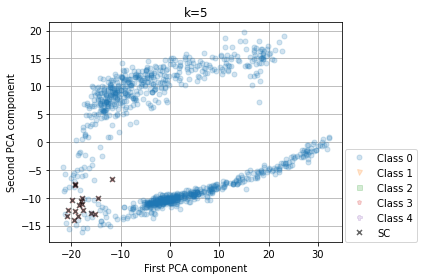

In [41]:
# Check where the SC are situated in the latent space
fig, axes = plt.subplots(1, 1)
instances = pca.transform(val_x)
plot_clusters(fig, axes, k=5, instances=instances, labels=val_y, sc=val_c.sc)

### Custom Metric

To implement an early-stopping technique, we must be able to measure progress of our training. We train the classifier to perform an auxiliary task. However, at the end, we are interested only to measure the performance in identifying the (true) SC instances.

Therefore, we will construct two metric. First one (an auxiliary one) will measure the true positive count of the identified SC instances. We need this, in order to see how many instances we missed (presumably, we might care about false negative more than false positive). Second metric will measure the AUC score in identifying the SC instances. We don't think that a simple accuracy is a good measure here, since we might have different weights for false negative and false positive.

In [42]:
# Build a custom metric
tf = tensorflow

class CustomMetric(tf.keras.metrics.Metric):
    """Only count if the SC class is correctly classified (true positive)."""

    def __init__(self, name='tp', sc_class=SC_CLASS_NUMBER, **kwargs):
        """Initialization."""
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.sc_class = sc_class
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Count the true positive."""
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, [-1])
        y_true = tf.equal(y_true, self.sc_class)
        
        y_pred = tf.cast(y_pred, tf.float32)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(y_pred, tf.int32)
        y_pred = tf.equal(y_pred, self.sc_class)        

        values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        values = tf.cast(values, self.dtype)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_to(sample_weight, values.shape)
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives
    
    
class MulticlassAUC(tf.keras.metrics.AUC):
    """AUC for a single class in a muliticlass problem."""

    def __init__(self, pos_label, sparse=True, from_logits=True, num_thresholds=5000, **kwargs):
        super().__init__(num_thresholds, **kwargs)
        self.pos_label = pos_label
        self.from_logits = from_logits
        self.sparse = sparse

    def update_state(self, y_true, y_pred, **kwargs):
        """Accumulates confusion matrix statistics."""
        if self.sparse:
            y_true = tf.math.equal(y_true, self.pos_label)
            y_true = tf.squeeze(y_true)
        else:
            y_true = y_true[..., self.pos_label]

        y_pred = tf.cast(y_pred, tf.float32)
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)
        y_pred = y_pred[..., self.pos_label]

        super().update_state(y_true, y_pred, **kwargs)


METRICS = [ 
    CustomMetric(name='tf', sc_class=SC_CLASS_NUMBER),
    MulticlassAUC(name='auc', pos_label=SC_CLASS_NUMBER, from_logits=False)
]

### Models and Training

We test here a few CNN models:
 1. The first model is a simply, one layer CNN network. We do not expect this model to perform very well - we use it just as a baseline model to judge how much improvement can provide different network architectures.
 2. The second model is an adapted version of an AlexNet.
 3. The third model is an adapted version of a VGG model.
 4. The last model is based on a pre-trained ResNet-v2 model, with custom head.
 
In each case, we keep the number of training parameters roughly equal (about 4.5 million).

In [43]:
# Simple CNN model
m1 = tensorflow.keras.models.Sequential()

m1.add(tensorflow.keras.layers.Conv2D(
    384, (15, 15), strides=8, padding="same", activation="relu", input_shape=(256, 256, 1)))
m1.add(tensorflow.keras.layers.MaxPooling2D((8, 8), strides=4))

m1.add(tensorflow.keras.layers.Flatten())
m1.add(tensorflow.keras.layers.Dense(256, activation = "relu"))
m1.add(tensorflow.keras.layers.Dropout(0.25))
m1.add(tensorflow.keras.layers.Dense(5, activation='softmax'))
m1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 384)       86784     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 384)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18816)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4817152   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 4,905,221
Trainable params: 4,905,221
Non-trainable params: 0
____________________________________________

In [44]:
# Compile
m1.compile(
    optimizer=tensorflow.keras.optimizers.Adam(1e-5),
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS
)

# Train
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=2, min_delta=0.002, mode='max'
)

m1_log =  m1.fit(
    augmented_train_data, augmented_train_y, epochs=30, verbose=1,
    validation_data=(val_data, val_y), callbacks=[callback]
)

Epoch 1/30
250/250 [==============================] - 3s 13ms/step - loss: 1.4357 - tf: 414.0000 - auc: 0.7291 - val_loss: 1.5839 - val_tf: 1.0000 - val_auc: 0.9421
Epoch 2/30
250/250 [==============================] - 3s 11ms/step - loss: 0.9462 - tf: 956.0000 - auc: 0.9447 - val_loss: 2.3215 - val_tf: 16.0000 - val_auc: 0.9525
Epoch 3/30
250/250 [==============================] - 3s 11ms/step - loss: 0.6720 - tf: 1277.0000 - auc: 0.9856 - val_loss: 2.8302 - val_tf: 16.0000 - val_auc: 0.9515
Epoch 4/30
250/250 [==============================] - 3s 11ms/step - loss: 0.5199 - tf: 1329.0000 - auc: 0.9890 - val_loss: 3.1503 - val_tf: 16.0000 - val_auc: 0.9473


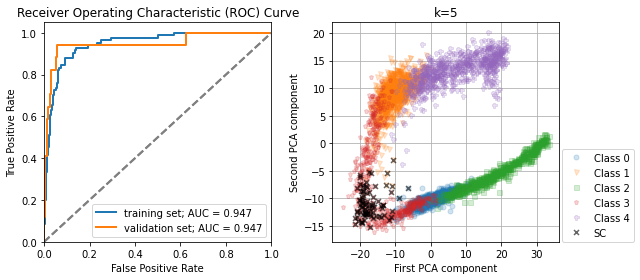

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Plot the ROC curve for the train data
pred = m1.predict(train_data)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_c.sc, pred[:,SC_CLASS_NUMBER], pos_label=1)
plot_roc_curve(fig, axes[0], fpr, tpr, info='training set')

# Check the new clusters
plot_clusters(fig, axes[1], k=5, instances=pca.transform(train_x), labels=pred.argmax(axis=-1), sc=train_c.sc)

# Plot the ROC curve for the test data
pred = m1.predict(val_data)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_c.sc, pred[:,SC_CLASS_NUMBER], pos_label=1)
plot_roc_curve(fig, axes[0], fpr, tpr, info='validation set')

In [46]:
# CNN inspired by AlexNet
m2 = tensorflow.keras.models.Sequential()

m2.add(tensorflow.keras.layers.Conv2D(
    128, (11, 11), strides=4, padding="same", activation="relu", input_shape=(256, 256, 1)))
m2.add(tensorflow.keras.layers.BatchNormalization())
m2.add(tensorflow.keras.layers.MaxPooling2D((4, 4), strides=4))

m2.add(tensorflow.keras.layers.Conv2D(256, (5, 5), strides=1, padding="same", activation="relu"))
m2.add(tensorflow.keras.layers.BatchNormalization())
m2.add(tensorflow.keras.layers.MaxPooling2D((2, 2), strides=2))

m2.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m2.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m2.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m2.add(tensorflow.keras.layers.BatchNormalization())
m2.add(tensorflow.keras.layers.MaxPooling2D((2, 2), strides=2))

m2.add(tensorflow.keras.layers.Flatten())
m2.add(tensorflow.keras.layers.Dense(512, activation="relu"))
m2.add(tensorflow.keras.layers.Dropout(0.25))
m2.add(tensorflow.keras.layers.Dense(5, activation='softmax'))
m2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 128)       15616     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 256)        

In [47]:
# Compile
m2.compile(
    optimizer=tensorflow.keras.optimizers.Adam(2e-5),
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS
)

# Train
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=2, min_delta=0.002, mode='max'
)

m2_log =  m2.fit(
    augmented_train_data, augmented_train_y, epochs=30, verbose=1,
    validation_data=(val_data, val_y), callbacks=[callback]
)

Epoch 1/30
250/250 [==============================] - 5s 22ms/step - loss: 0.4028 - tf: 1237.0000 - auc: 0.9524 - val_loss: 3.0034 - val_tf: 17.0000 - val_auc: 0.8030
Epoch 2/30
250/250 [==============================] - 5s 20ms/step - loss: 0.0661 - tf: 1520.0000 - auc: 0.9980 - val_loss: 3.7540 - val_tf: 16.0000 - val_auc: 0.8701
Epoch 3/30
250/250 [==============================] - 5s 20ms/step - loss: 0.0314 - tf: 1560.0000 - auc: 0.9996 - val_loss: 8.0314 - val_tf: 16.0000 - val_auc: 0.9180
Epoch 4/30
250/250 [==============================] - 5s 21ms/step - loss: 0.0339 - tf: 1553.0000 - auc: 0.9993 - val_loss: 12.2886 - val_tf: 16.0000 - val_auc: 0.9229
Epoch 5/30
250/250 [==============================] - 5s 20ms/step - loss: 0.0185 - tf: 1579.0000 - auc: 0.9997 - val_loss: 13.7947 - val_tf: 16.0000 - val_auc: 0.9237
Epoch 6/30
250/250 [==============================] - 5s 21ms/step - loss: 0.0149 - tf: 1582.0000 - auc: 0.9998 - val_loss: 12.1554 - val_tf: 16.0000 - val_auc: 0.

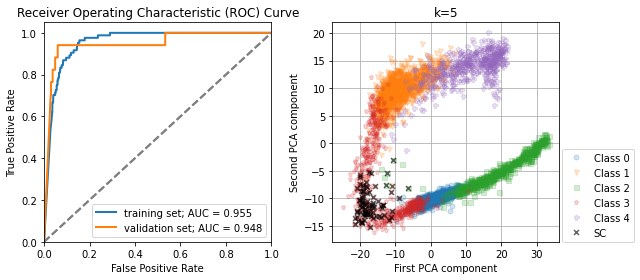

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Plot the ROC curve for the train data
pred = m2.predict(train_data)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_c.sc, pred[:,SC_CLASS_NUMBER], pos_label=1)
plot_roc_curve(fig, axes[0], fpr, tpr, info='training set')

# Check the new clusters
plot_clusters(fig, axes[1], k=5, instances=pca.transform(train_x), labels=pred.argmax(axis=-1), sc=train_c.sc)

# Plot the ROC curve for the test data
pred = m2.predict(val_data)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_c.sc, pred[:,SC_CLASS_NUMBER], pos_label=1)
plot_roc_curve(fig, axes[0], fpr, tpr, info='validation set')

In [49]:
# Inspired by VGG16
m3 = tensorflow.keras.models.Sequential()

m3.add(tensorflow.keras.layers.Conv2D(
    64, (3, 3), strides=2, padding="same", activation="relu", input_shape=(256, 256, 1)))
m3.add(tensorflow.keras.layers.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.MaxPooling2D((2, 2)))

m3.add(tensorflow.keras.layers.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.MaxPooling2D((2, 2)))

m3.add(tensorflow.keras.layers.Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.BatchNormalization())
m3.add(tensorflow.keras.layers.MaxPooling2D((2, 2)))

m3.add(tensorflow.keras.layers.Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.MaxPooling2D((2, 2)))

m3.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
m3.add(tensorflow.keras.layers.MaxPooling2D((2, 2)))

m3.add(tensorflow.keras.layers.Flatten())
m3.add(tensorflow.keras.layers.Dense(512, activation = "relu"))
m3.add(tensorflow.keras.layers.Dropout(0.25))
m3.add(tensorflow.keras.layers.Dense(5, activation='softmax'))
m3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)      

In [50]:
# Compile
m3.compile(
    optimizer=tensorflow.keras.optimizers.Adam(5e-5),
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS
)

# Train
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=2, min_delta=0.001, mode='max'
)

m3_log =  m3.fit(
    augmented_train_data, augmented_train_y, epochs=30, verbose=1,
    validation_data=(val_data, val_y), callbacks=[callback]
)

Epoch 1/30
250/250 [==============================] - 17s 68ms/step - loss: 0.2722 - tf: 1327.0000 - auc: 0.9687 - val_loss: 2.0817 - val_tf: 13.0000 - val_auc: 0.9021
Epoch 2/30
250/250 [==============================] - 17s 67ms/step - loss: 0.0785 - tf: 1498.0000 - auc: 0.9958 - val_loss: 3.7511 - val_tf: 16.0000 - val_auc: 0.9176
Epoch 3/30
250/250 [==============================] - 17s 67ms/step - loss: 0.0521 - tf: 1544.0000 - auc: 0.9986 - val_loss: 8.4392 - val_tf: 16.0000 - val_auc: 0.9256
Epoch 4/30
250/250 [==============================] - 17s 67ms/step - loss: 0.0301 - tf: 1555.0000 - auc: 0.9994 - val_loss: 10.5995 - val_tf: 16.0000 - val_auc: 0.9242
Epoch 5/30
250/250 [==============================] - 17s 67ms/step - loss: 0.0499 - tf: 1548.0000 - auc: 0.9993 - val_loss: 10.6159 - val_tf: 16.0000 - val_auc: 0.9530
Epoch 6/30
250/250 [==============================] - 17s 67ms/step - loss: 0.0292 - tf: 1562.0000 - auc: 0.9991 - val_loss: 6.1835 - val_tf: 15.0000 - val_au

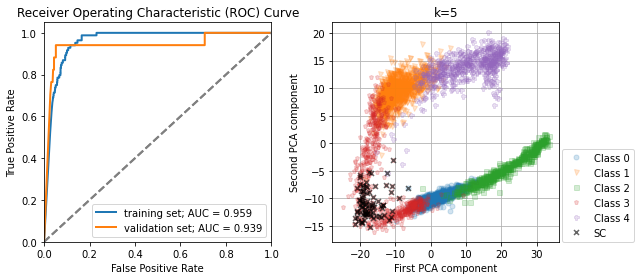

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Plot the ROC curve for the train data
pred = m3.predict(train_data)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_c.sc, pred[:,SC_CLASS_NUMBER], pos_label=1)
plot_roc_curve(fig, axes[0], fpr, tpr, info='training set')

# Check the new clusters
plot_clusters(fig, axes[1], k=5, instances=pca.transform(train_x), labels=pred.argmax(axis=-1), sc=train_c.sc)

# Plot the ROC curve for the test data
pred = m3.predict(val_data)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_c.sc, pred[:,SC_CLASS_NUMBER], pos_label=1)
plot_roc_curve(fig, axes[0], fpr, tpr, info='validation set')

In [52]:
# Transfer Learning (based on ResNet)
m4 = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4", trainable=False),
    tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(2048, activation='sigmoid'),
    tensorflow.keras.layers.Dropout(0.25),
    tensorflow.keras.layers.Dense(5, activation='softmax')
])
m4.build([None, 256, 256, 3])
m4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 10245     
Total params: 27,771,397
Trainable params: 4,206,597
Non-trainable params: 23,564,800
_________________________________________________________________


In [53]:
# Compile
m4.compile(
    optimizer=tensorflow.keras.optimizers.Adam(1e-5),
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS
)

# Train
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=2, min_delta=0.001, mode='max'
)

augmented_train_data3 = numpy.repeat(augmented_train_data, 3, axis=-1)
val_data3 = numpy.repeat(val_data, 3, axis=-1)

m4_log =  m4.fit(
    augmented_train_data3, augmented_train_y, epochs=30, verbose=1,
    validation_data=(val_data3, val_y), callbacks=[callback]
)

Epoch 1/30
250/250 [==============================] - 29s 115ms/step - loss: 0.9910 - tf: 1353.0000 - auc: 0.9542 - val_loss: 1.8568 - val_tf: 17.0000 - val_auc: 0.9832
Epoch 2/30
250/250 [==============================] - 28s 111ms/step - loss: 0.3977 - tf: 1516.0000 - auc: 0.9996 - val_loss: 2.3638 - val_tf: 17.0000 - val_auc: 0.9840
Epoch 3/30
250/250 [==============================] - 28s 111ms/step - loss: 0.2239 - tf: 1543.0000 - auc: 0.9999 - val_loss: 2.8027 - val_tf: 17.0000 - val_auc: 0.9844
Epoch 4/30
250/250 [==============================] - 28s 111ms/step - loss: 0.1449 - tf: 1567.0000 - auc: 1.0000 - val_loss: 3.2638 - val_tf: 17.0000 - val_auc: 0.9845
Epoch 5/30
250/250 [==============================] - 28s 111ms/step - loss: 0.1055 - tf: 1575.0000 - auc: 0.9999 - val_loss: 3.5280 - val_tf: 17.0000 - val_auc: 0.9848


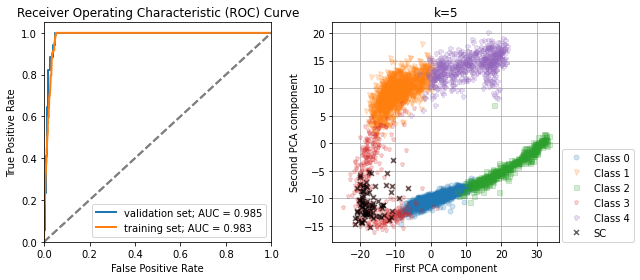

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Plot the ROC curve for the test data
pred = m4.predict(val_data3)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_c.sc, pred[:,SC_CLASS_NUMBER], pos_label=1)
plot_roc_curve(fig, axes[0], fpr, tpr, info='validation set')

# Plot the ROC curve for the train data
pred = m4.predict(numpy.repeat(train_data, 3, axis=-1))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_c.sc, pred[:,SC_CLASS_NUMBER], pos_label=1)
plot_roc_curve(fig, axes[0], fpr, tpr, info='training set')

# Check the new clusters
plot_clusters(fig, axes[1], k=5, instances=pca.transform(train_x), labels=pred.argmax(axis=-1), sc=train_c.sc)

## Section 6: Testing

We use the test dataset to check which method is yields the best results. Note, that we tuned the models only using the training and validation set. Up to the very last moment, we never looked at the test dataset. We only open it now, to compare the performance of our models and to see if there is any improvement over the baseline.

In [55]:
# Load the test data
test_data = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_test500x_256f16.npy')).astype('float32')
test_data.shape, test_data.dtype

((500, 256, 256, 1), dtype('float32'))

(0.0, 1.0, 0.499968)

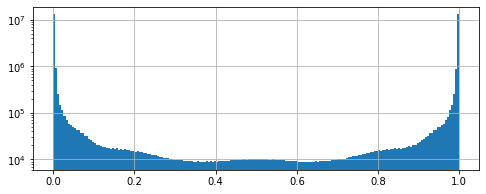

In [56]:
# Standarize the test data
test_data = numpy.where(test_data > 1, 1, test_data)
test_data = numpy.where(test_data < -1, -1, test_data)
test_data += 1
test_data /= 2

# Plot the distribution again (note, now the distribution is from 0 to 1)
fig, ax = plt.subplots()
pandas.Series(test_data.flatten()).hist(bins=200, figsize=(8, 3))
ax.set_yscale('log')
test_data.min(), test_data.max(), test_data.mean()

In [57]:
# Load the input data casted to the latent space
test_x = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_test500f_256f16_ResNetV2.npy'))
test_x.shape

(500, 2048)

In [58]:
# Load and show the labels
test_c = pandas.read_csv(os.path.join(DATA_PATH, 'cah_lastframe_test500c_256f16.csv'))
test_c

,pos,neg,pos_pbc,neg_pbc
0,0,hv,0,hv
1,0,hv,0,hv
2,hv,0,hv,0
3,hv,0,hv,0
4,0,hv,0,hv
...,...,...,...,...
495,hv,0,hv,0
496,hv,0,hv,0
497,0,hv,0,hv
498,hv,0,hv,0


In [59]:
# Mark "spaning clusters" (sc), dominant positive (+), and dominant negative (-) cases
test_c['sc'] = [int(row.pos != 'hv' and row.neg != 'hv') for _, row in test_c.iterrows()]
test_c['+'] = [int(row.pos == 'hv' and row.neg != 'hv') for _, row in test_c.iterrows()]
test_c['-'] = [int(row.pos != 'hv' and row.neg == 'hv') for _, row in test_c.iterrows()]
test_c.tail()

,pos,neg,pos_pbc,neg_pbc,sc,+,-
495,hv,0,hv,0,0,1,0
496,hv,0,hv,0,0,1,0
497,0,hv,0,hv,0,0,1
498,hv,0,hv,0,0,1,0
499,hv,0,hv,0,0,1,0


In [60]:
# test baseline 1
test_distance = numpy.linalg.norm(test_x - sc_center, axis=1)
fprB1, tprB1, thresholds = sklearn.metrics.roc_curve(test_c.sc, 1/test_distance, pos_label=1)

# test baseline 2
pred = m0.predict(test_data)[:,3]
fprB2, tprB2, thresholds = sklearn.metrics.roc_curve(test_c.sc, pred, pos_label=1)

In [61]:
# test Model 1
pred = m1.predict(test_data)[:,3]
fprM1, tprM1, thresholds = sklearn.metrics.roc_curve(test_c.sc, pred, pos_label=1)

# test Model 2
pred = m2.predict(test_data)[:,3]
fprM2, tprM2, thresholds = sklearn.metrics.roc_curve(test_c.sc, pred, pos_label=1)

# test Model 3
pred = m3.predict(test_data)[:,3]
fprM3, tprM3, thresholds = sklearn.metrics.roc_curve(test_c.sc, pred, pos_label=1)

# test Model 4
pred = m4.predict(numpy.repeat(test_data, 3, axis=-1))[:,3]
fprM4, tprM4, thresholds = sklearn.metrics.roc_curve(test_c.sc, pred, pos_label=1)

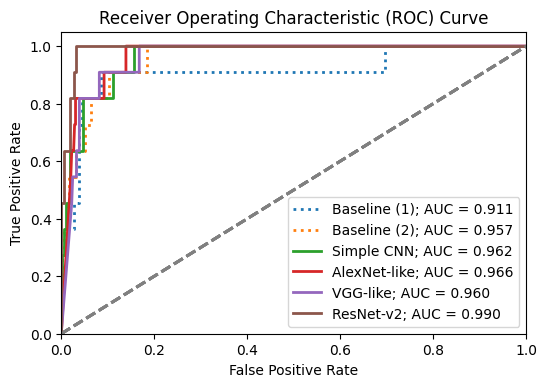

In [62]:
fig, axes = plt.subplots(1, 1, dpi=100)
plot_roc_curve(fig, axes, fprB1, tprB1, info='Baseline (1)', style=':')
plot_roc_curve(fig, axes, fprB2, tprB2, info='Baseline (2)', style=':')
plot_roc_curve(fig, axes, fprM1, tprM1, info='Simple CNN')
plot_roc_curve(fig, axes, fprM2, tprM2, info='AlexNet-like')
plot_roc_curve(fig, axes, fprM3, tprM3, info='VGG-like')
plot_roc_curve(fig, axes, fprM4, tprM4, info='ResNet-v2')

## Summary

We presented how to train a classifiers that are capable of detecting the SC without explicit access to the true labels. We used a several techniques including the label propagation, the Teacher-Student framework, and the transfer learning. The input was mapped to the latent space using the pre-trained ResNet-v2 model. We used the k-Means to cluster the data in the latent space. We used the information about the centroid position to select "clean" data instances and we leveraged the periodic boundary conditions to augment the training data. We tested several classifiers and we have shown that all of them overperform the baseline models. The model with the best performance was trained using a transfer learning technique.

Additional advantage is that the new clusters better capture the edge cases. Using k-Means the borders between the clusters is sharp. It is known that the classification of the instances that lay close to borders can be easily influenced by adding or removing single training examples. The new clusters have fuzzy borders (see below) and might be more robust to such manipulations (see the Figures below).

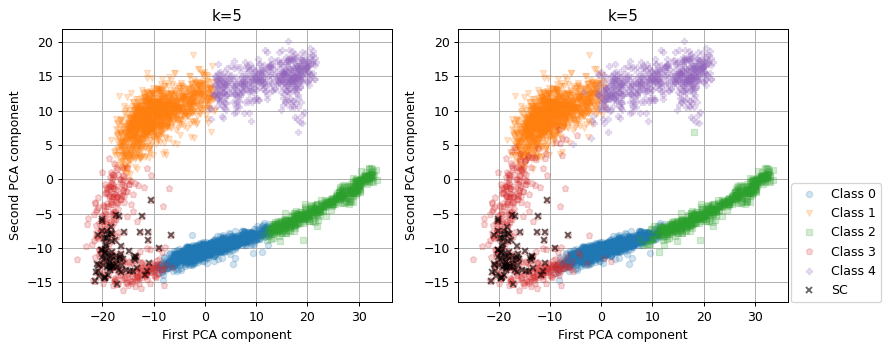

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=90)

# Old clusters (using k-Means)
plot_clusters(
    fig, axes[0], k=5, instances=pca.transform(train_x),
    labels=train_y, sc=train_c.sc, legend=False)

# New Clusters (using ResNet)
pred = m4.predict(numpy.repeat(train_data, 3, axis=-1))
plot_clusters(
    fig, axes[1], k=5, instances=pca.transform(train_x),
    labels=pred.argmax(axis=-1), sc=train_c.sc)